In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [67]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [68]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD

# Load the data

In [4]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")

y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

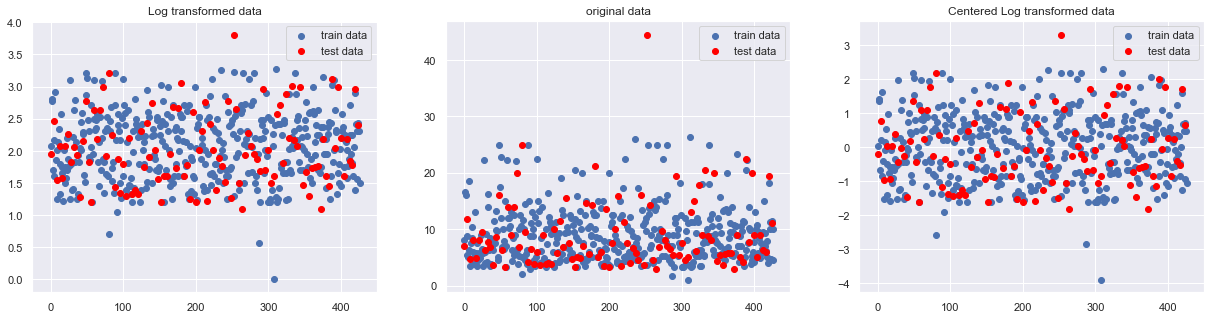

In [5]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

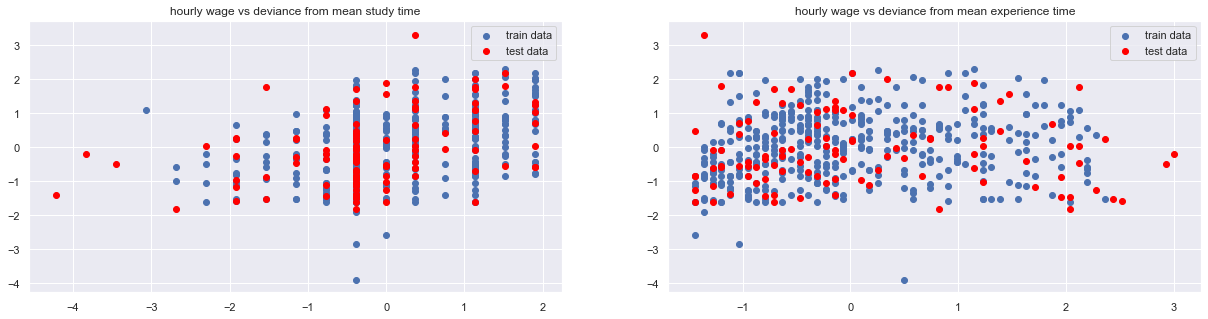

In [6]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [7]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

# Obtaining estimates

## using MAP

#### using vanilla gradient descent

In [8]:
GD.vanilla_gd(model_gaussian, max_iter= 8000)
GD.vanilla_gd(model_student, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:15
Progress : [====================] 100% Done...
   duration: 0:00:19


#### using line search

In [9]:
GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 797  duration: 0:00:02


In [10]:
GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000)

Progress : [====================] 100% Done...
   duration: 0:00:28


#### using Wolfe condition to adpat the step size

In [11]:
GD.Wolfe_cond_gd(model_gaussian, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [====================] 100% Done...
   duration: 0:00:27


In [12]:
GD.Wolfe_cond_gd(model_student, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size))

Progress : [====================] 100% Done...
   duration: 0:00:39


## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 16.1%  (advised values between 10% and 50%)
  duration: 0:00:11
iterations


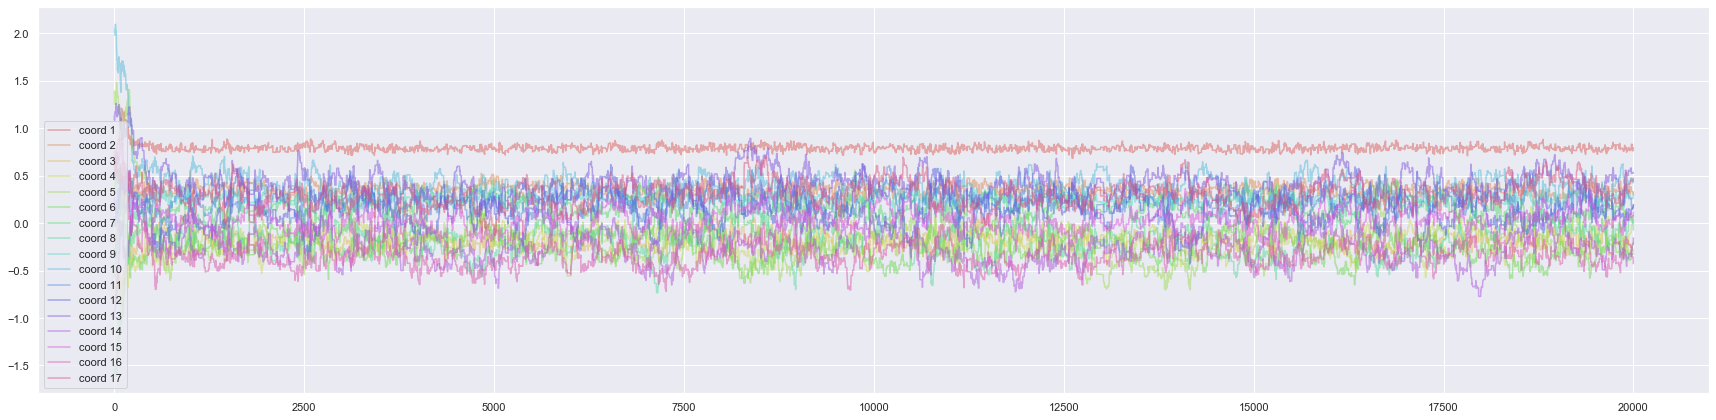

In [41]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 39.3%  (advised values between 10% and 50%)
  duration: 0:00:14
iterations


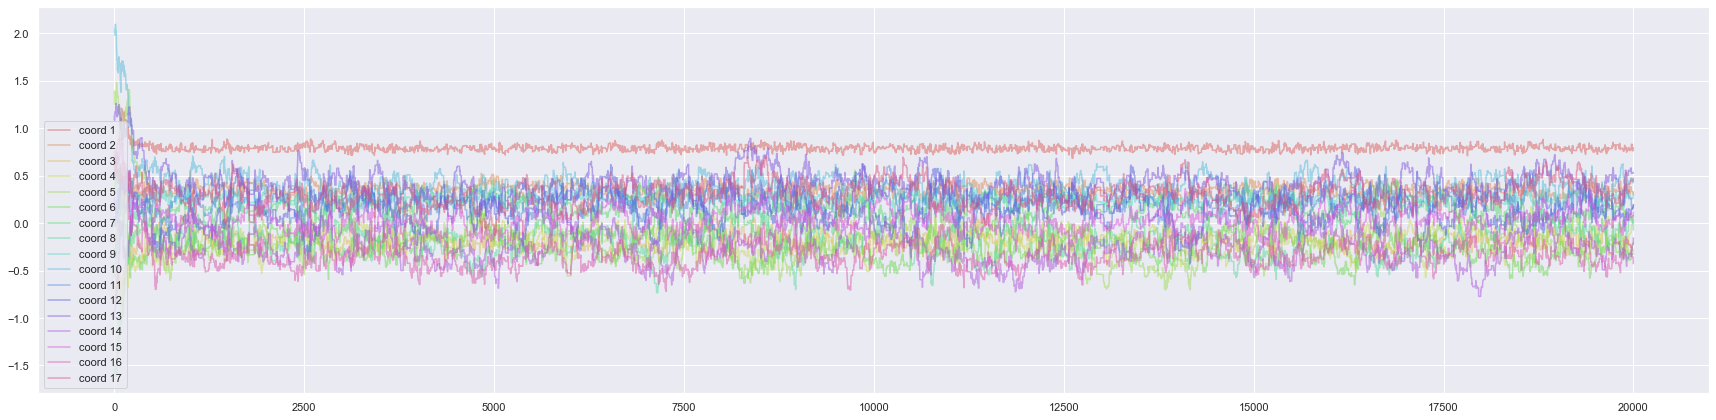

In [42]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 59.8%  (advised values between 10% and 50%)
  duration: 0:01:30
iterations


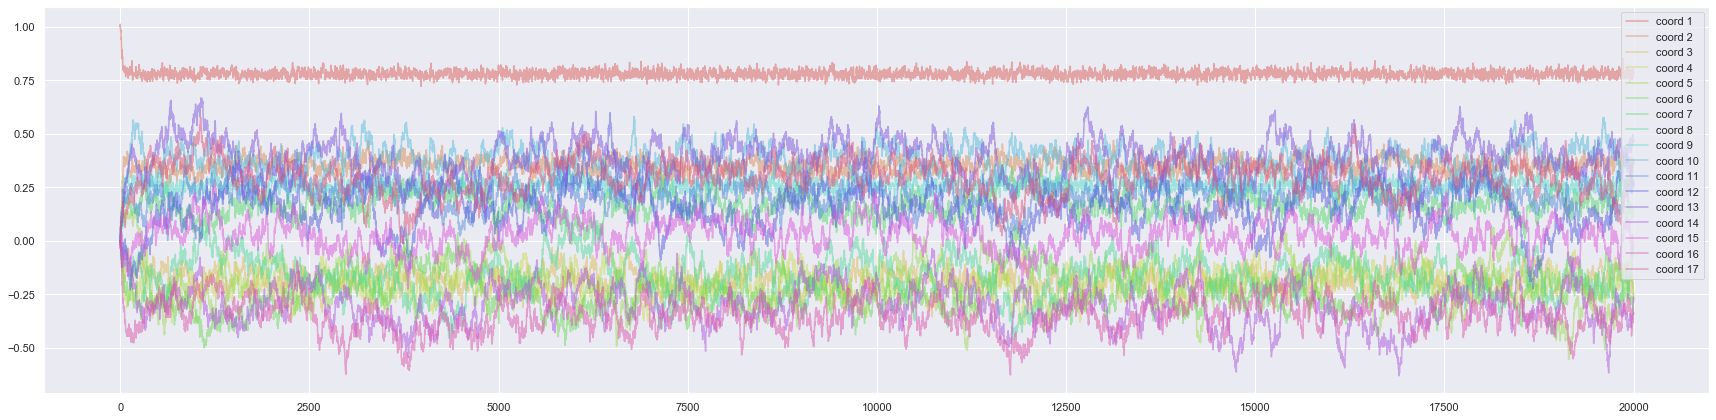

In [43]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.0%  (advised values between 10% and 50%)
  duration: 0:01:54
iterations


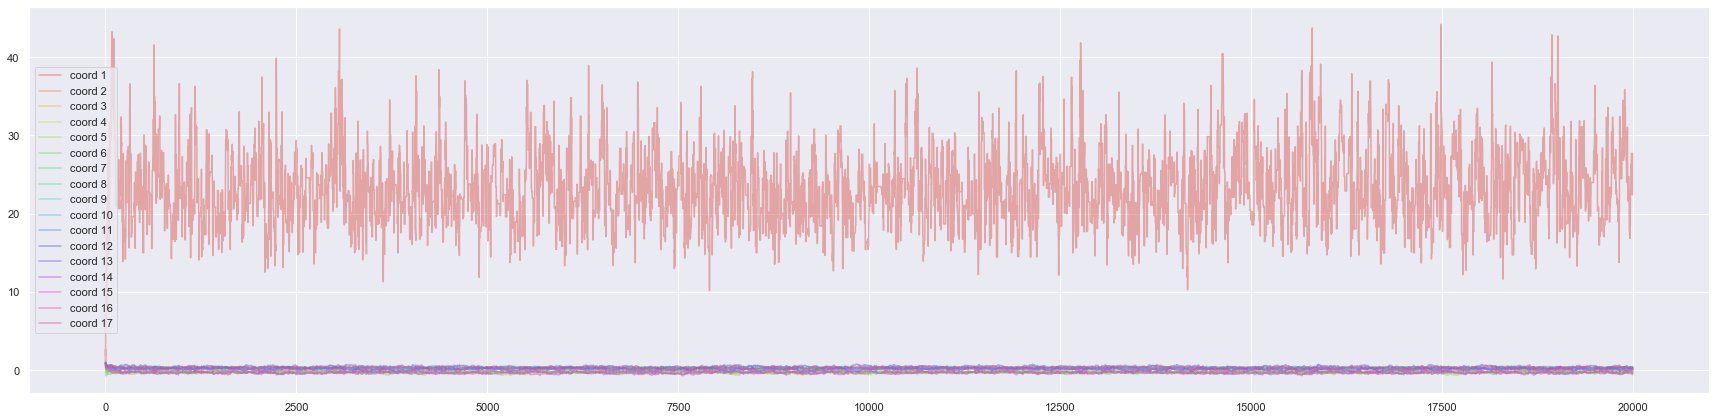

In [44]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### comparison of the metropolis hastings chains

gaussian model

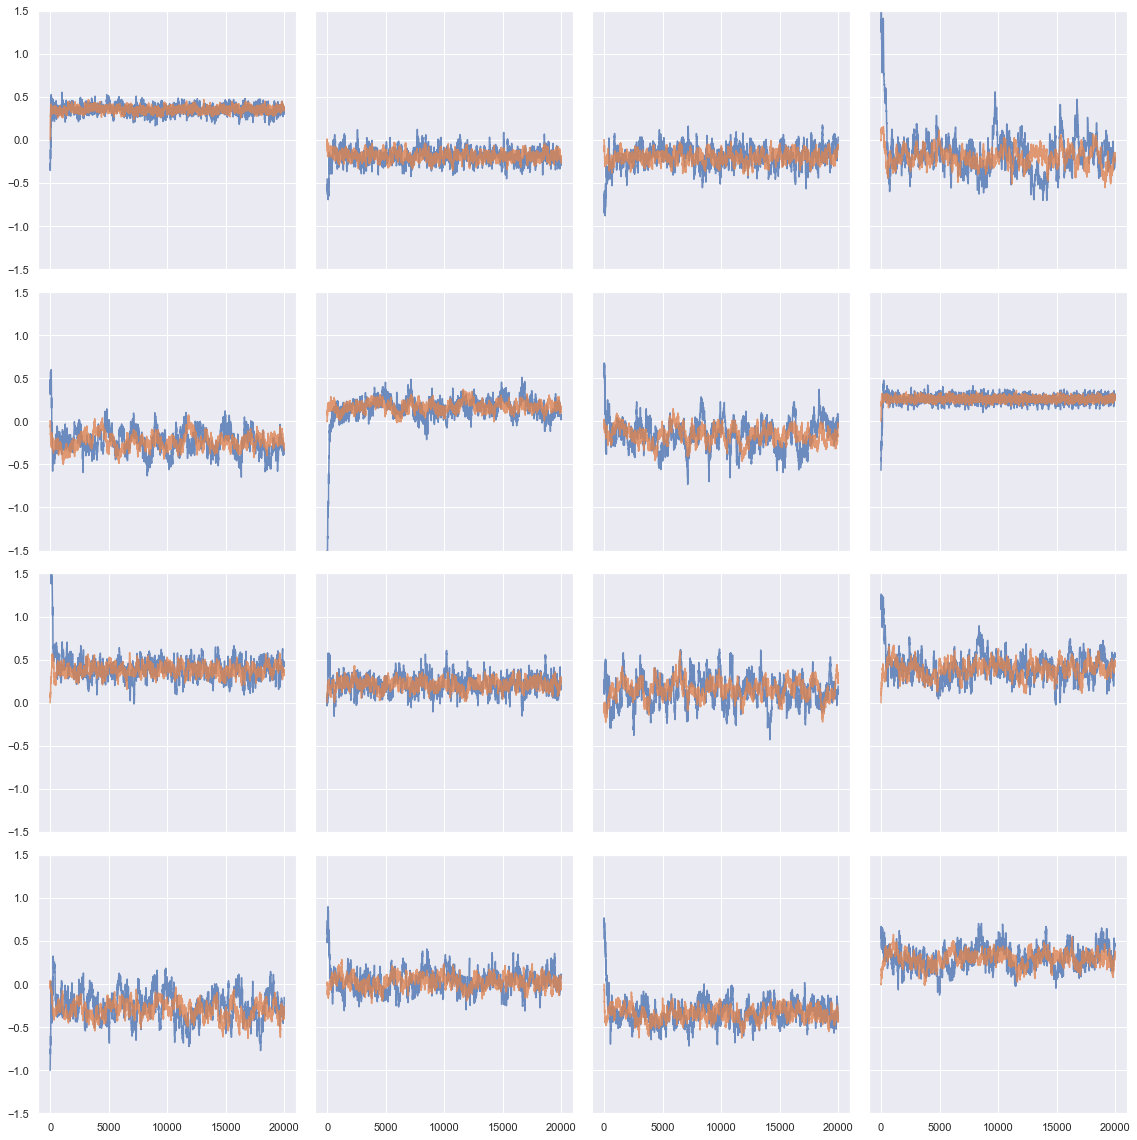

In [46]:
compare_samples_MH(samples_gaussian_rw,samples_gaussian_langevin)

student model

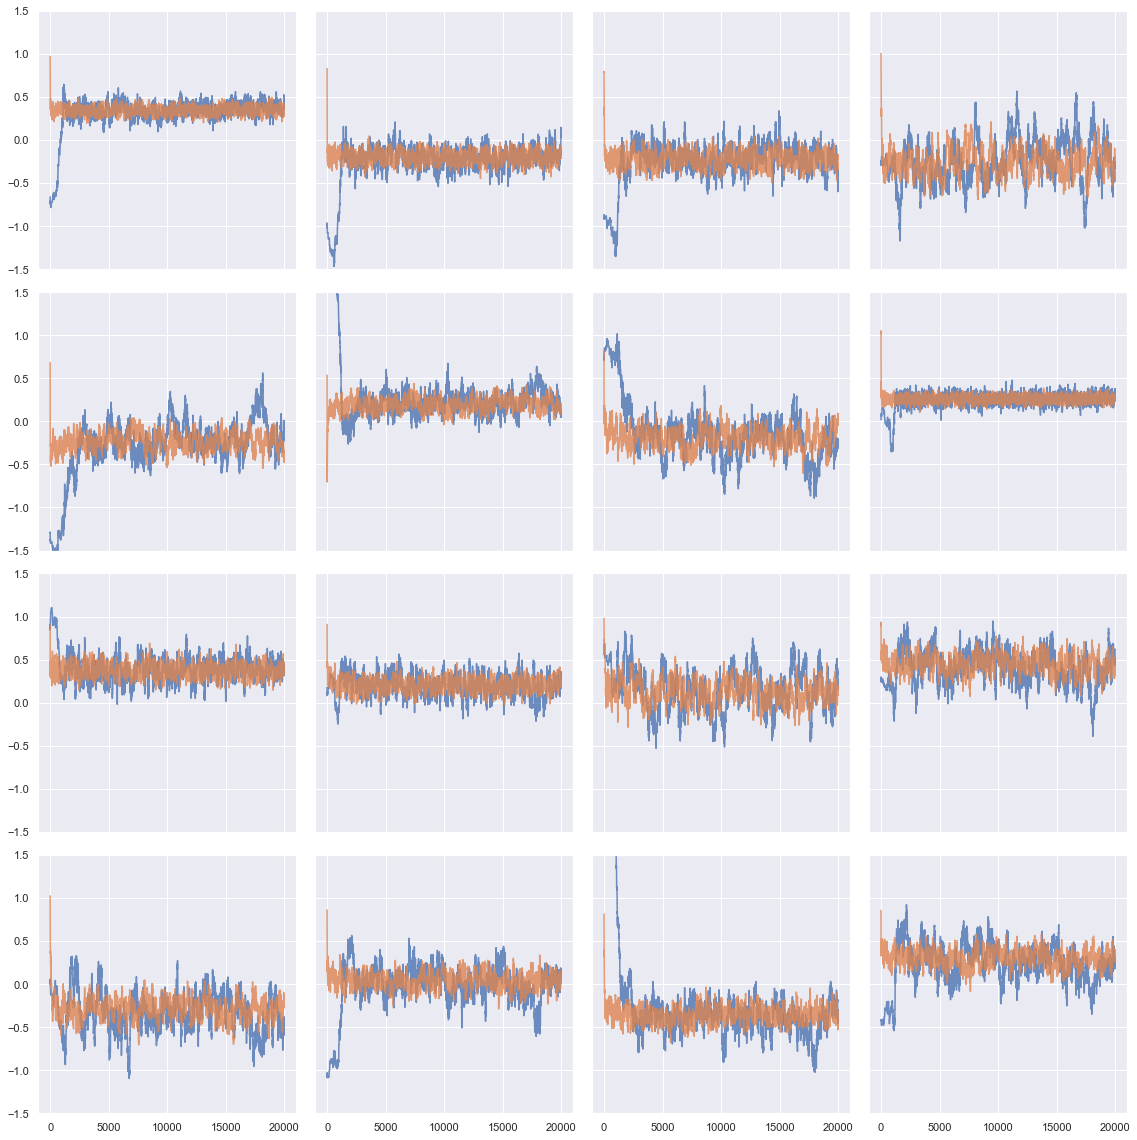

In [47]:
compare_samples_MH(samples_student_rw,samples_student_langevin)

### extraction of the estimates from the models

In [48]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
gd                  0.773617  0.351707 -0.185607 -0.204573 -0.212707   
line_search_gd      0.773617  0.351707 -0.185607 -0.204573 -0.212708   
Wolfe_cond_gd       0.937500  0.467542  0.014844  0.226920  0.410712   
MH_vanilla_mean     0.789374  0.350081 -0.187235 -0.184429 -0.180434   
MH_vanilla_median   0.788459  0.352950 -0.187634 -0.180531 -0.178049   
MH_Langevin_mean    0.779486  0.354288 -0.187203 -0.201484 -0.204341   
MH_Langevin_median  0.779310  0.354230 -0.187304 -0.202218 -0.205104   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.239069  0.169969 -0.162222  0.258266  0.385554   
line_search_gd     -0.239071  0.169967 -0.162219  0.258266  0.385554   
Wolfe_cond_gd      -0.229593 -0.202774 -0.022500  0.332110  0.352425   
MH_vanilla_mean    -0.245635  0.166317 -0.163920  0.256556  0.382158   
MH_vanilla_median  -0.249979  0.168056 -0.155672  0.256860  0.388284   
MH_Langevin_mean   -0.230380  0.173387 -0.168535  0.259675  0.381629   
MH_Langevin_median -0.235605  0.173016 -0.166743  0.259857  0.381022   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.212763  0.141788  0.393541 -0.297683  0.025753   
line_search_gd      0.212764  0.141789  0.393543 -0.297681  0.025755   
Wolfe_cond_gd       0.328985  0.457122  0.419534  0.369744  0.224076   
MH_vanilla_mean     0.212278  0.135500  0.395597 -0.259572  0.027222   
MH_vanilla_median   0.211844  0.132126  0.392397 -0.265623  0.026301   
MH_Langevin_mean    0.211941  0.155447  0.386090 -0.302934  0.024840   
MH_Langevin_median  0.213165  0.153829  0.393011 -0.302249  0.027684   

                        SERV      PROF  
gd                 -0.345084  0.297531  
line_search_gd     -0.345082  0.297534  
Wolfe_cond_gd       0.208475  0.328472  
MH_vanilla_mean    -0.341266  0.305143  
MH_vanilla_median  -0.345385  0.297424  
MH_Langevin_mean   -0.353158  0.290368  
MH_Langevin_median -0.351075  0.297133

In [49]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
gd                   6.706472  0.339510 -0.204350 -0.240561 -0.297032   
line_search_gd      18.744119  0.341741 -0.197535 -0.220067 -0.256264   
Wolfe_cond_gd        6.339830  0.339387 -0.204712 -0.242420 -0.299998   
MH_vanilla_mean     24.788731  0.350007 -0.205148 -0.198972 -0.227473   
MH_vanilla_median   23.680215  0.350317 -0.205757 -0.197265 -0.239128   
MH_Langevin_mean    23.204222  0.342242 -0.201232 -0.220387 -0.259919   
MH_Langevin_median  22.838222  0.342647 -0.202112 -0.218784 -0.258788   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.264903  0.207359 -0.188198  0.264394  0.365753   
line_search_gd     -0.251051  0.190463 -0.178088  0.260819  0.373601   
Wolfe_cond_gd      -0.267034  0.207635 -0.187642  0.264635  0.365522   
MH_vanilla_mean    -0.205107  0.217697 -0.212380  0.260931  0.373628   
MH_vanilla_median  -0.232053  0.213217 -0.184906  0.260613  0.374410   
MH_Langevin_mean   -0.229050  0.197059 -0.202364  0.260316  0.377443   
MH_Langevin_median -0.229324  0.194041 -0.201860  0.259935  0.378742   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.205116  0.122329  0.503266 -0.280779  0.059332   
line_search_gd      0.206468  0.129351  0.461792 -0.290331  0.042638   
Wolfe_cond_gd       0.205477  0.122620  0.506597 -0.278924  0.061327   
MH_vanilla_mean     0.196176  0.126318  0.407772 -0.340558  0.013205   
MH_vanilla_median   0.198374  0.120439  0.418717 -0.351702  0.014666   
MH_Langevin_mean    0.204655  0.119830  0.448280 -0.288935  0.038733   
MH_Langevin_median  0.205927  0.121102  0.449793 -0.287999  0.039747   

                        SERV      PROF  
gd                 -0.359705  0.312777  
line_search_gd     -0.351271  0.308540  
Wolfe_cond_gd      -0.359544  0.313935  
MH_vanilla_mean    -0.392044  0.264160  
MH_vanilla_median  -0.384661  0.261830  
MH_Langevin_mean   -0.358467  0.300462  
MH_Langevin_median -0.363768  0.301522

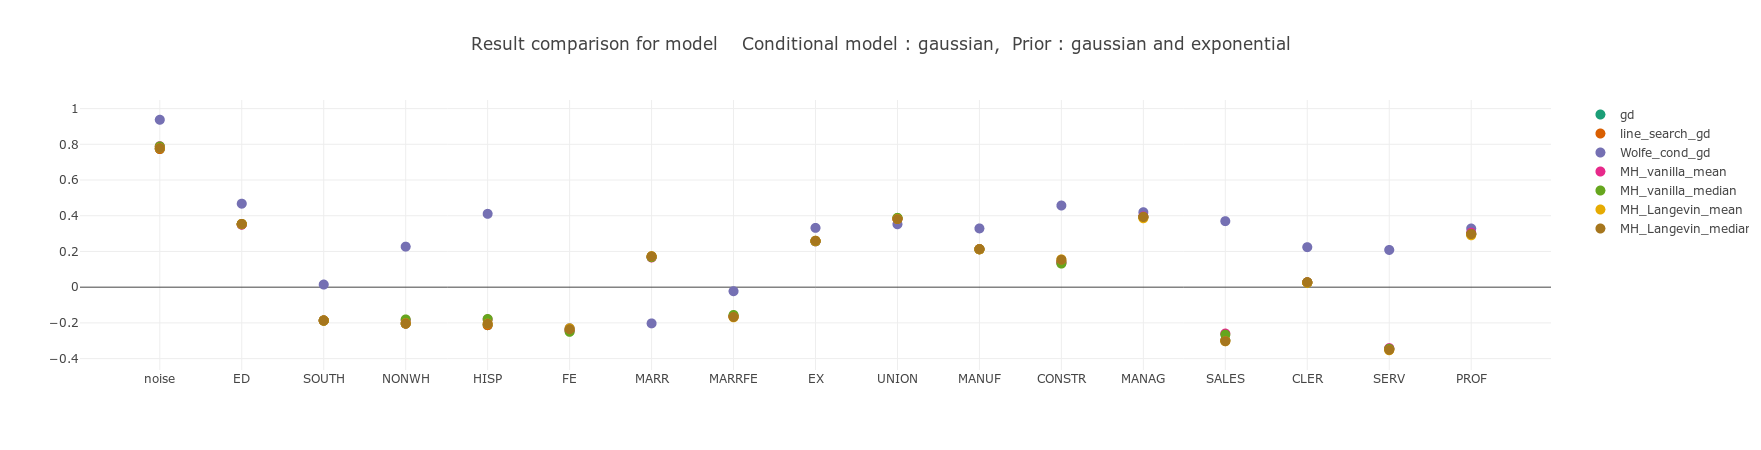

In [75]:
visualisation(r_gaussian,model_gaussian)

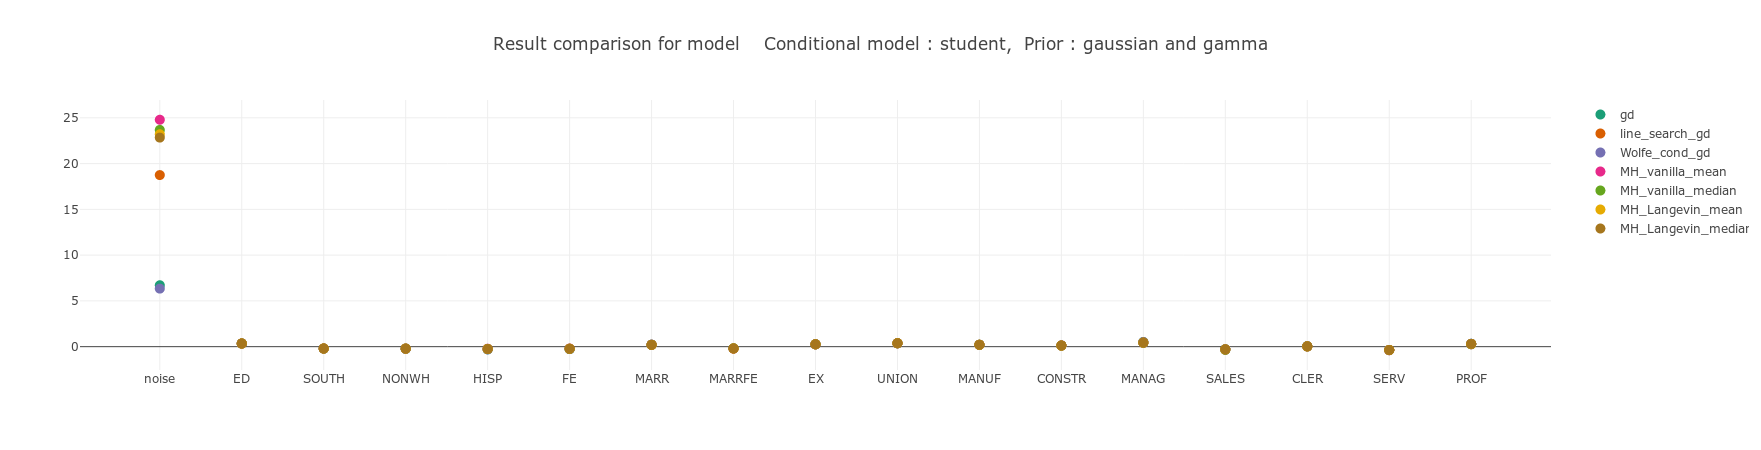

In [76]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In [53]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test)]
errors_student.index = ["average error"]
errors_student.T

average error
gd                       0.685301
line_search_gd           0.685159
Wolfe_cond_gd            0.685284
MH_vanilla_mean          0.689226
MH_vanilla_median        0.687735
MH_Langevin_mean         0.686293
MH_Langevin_median       0.686498

In [54]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test)]
errors_gaussian.index = ["average error"]
errors_gaussian.T

average error
gd                       0.685706
line_search_gd           0.685706
Wolfe_cond_gd            0.738525
MH_vanilla_mean          0.684238
MH_vanilla_median        0.684321
MH_Langevin_mean         0.686848
MH_Langevin_median       0.686144

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

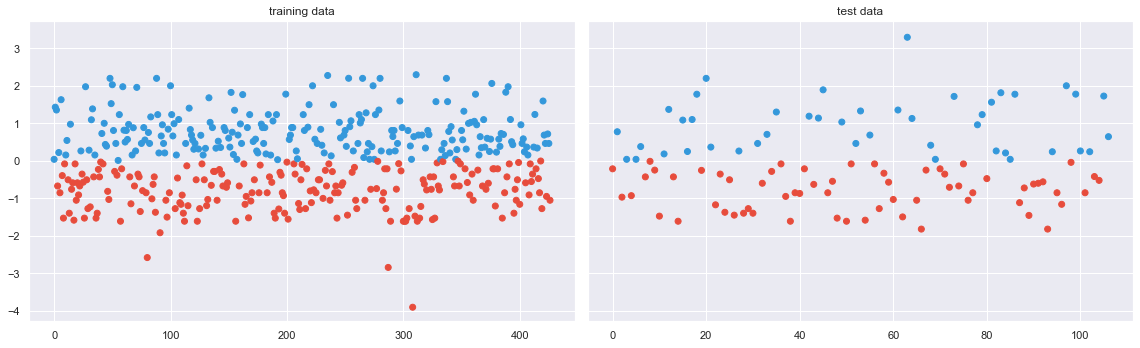

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

In [78]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,3*np.ones(16)],cond_model = [2])

Progress : [====================] 100% Done...
  Acceptance rate : 37.8%  (advised values between 10% and 50%)
  duration: 0:00:27
iterations


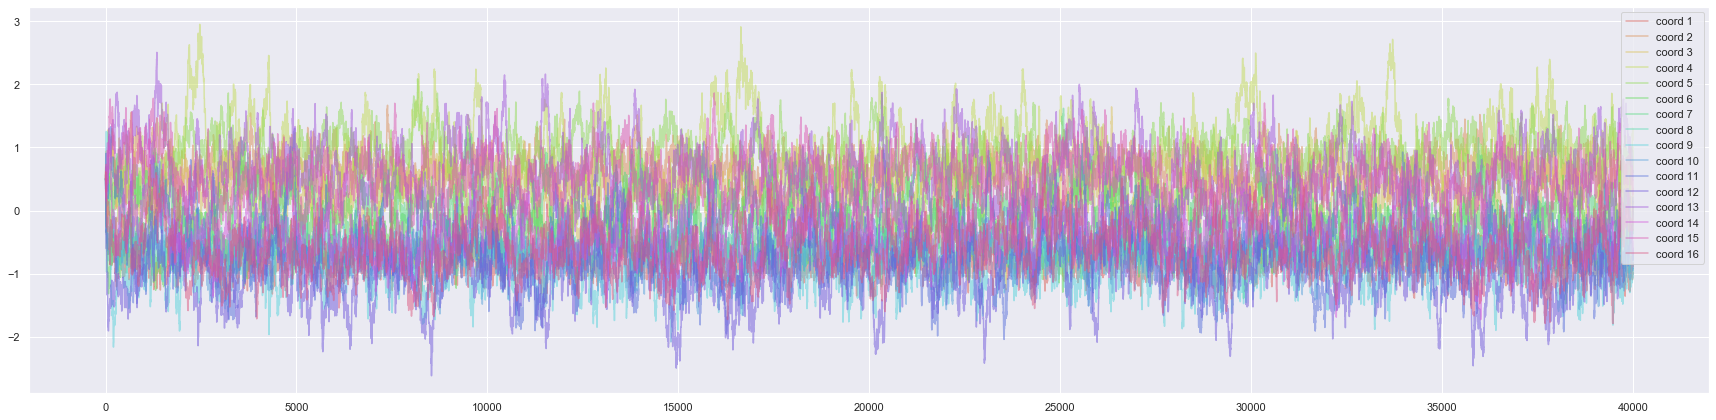

In [79]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 18.5%  (advised values between 10% and 50%)
  duration: 0:01:29
iterations


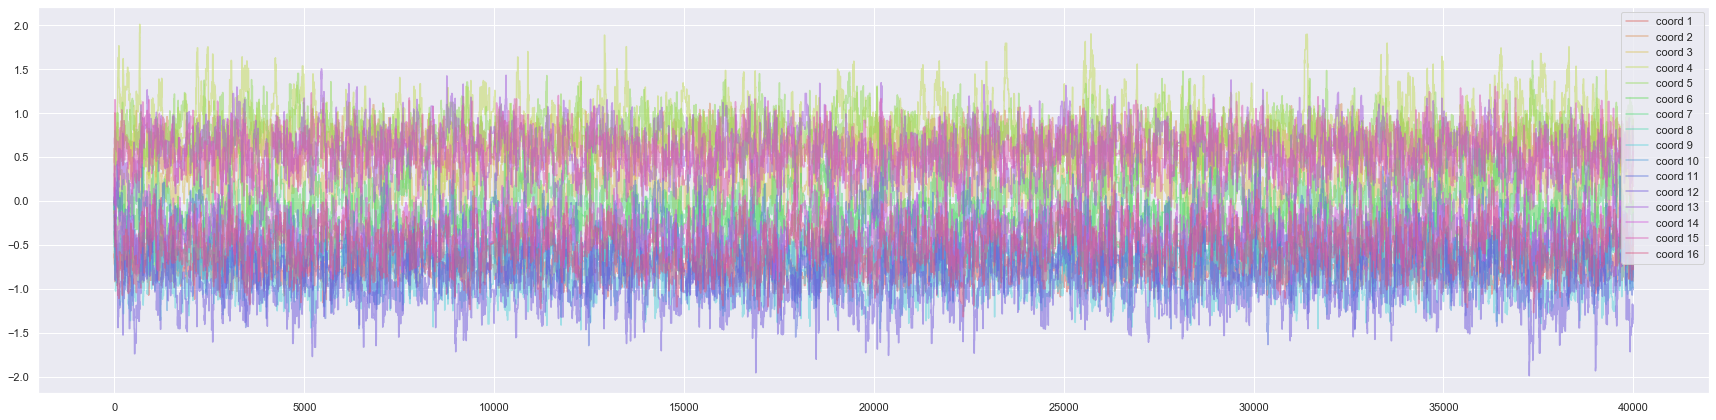

In [80]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

In [81]:
r_multilogi = multilogi()
r_multilogi.T

ED     SOUTH     NONWH      HISP        FE  \
MH_vanilla_mean    -0.785727  0.657438  0.205057  0.810291  0.785257   
MH_vanilla_median  -0.785257  0.661009  0.212002  0.795646  0.800701   
MH_Langevin_mean   -0.765272  0.643686  0.203870  0.762126  0.721154   
MH_Langevin_median -0.763749  0.646301  0.203062  0.758569  0.722257   

                        MARR    MARRFE        EX     UNION     MANUF  \
MH_vanilla_mean    -0.264342 -0.086589 -0.597534 -0.934336 -0.686094   
MH_vanilla_median  -0.260869 -0.105879 -0.596209 -0.932920 -0.685238   
MH_Langevin_mean   -0.306224 -0.051987 -0.576278 -0.877867 -0.640228   
MH_Langevin_median -0.310789 -0.051581 -0.574782 -0.877381 -0.638553   

                      CONSTR     MANAG     SALES      CLER      SERV      PROF  
MH_vanilla_mean    -0.554763 -0.976731  0.561570 -0.401181  0.519298 -0.607728  
MH_vanilla_median  -0.549707 -0.958100  0.557563 -0.405418  0.524361 -0.612980  
MH_Langevin_mean   -0.490783 -0.945116  0.544224 -0.322816  0.553928 -0.536010  
MH_Langevin_median -0.486957 -0.952304  0.541377 -0.327523  0.552102 -0.529444

## Results of logistic regression

In [82]:
predictions = multilogi.predict(X_test)
fitted = multilogi.predict(X)

In [83]:
errors = {}

In [84]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [85]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [86]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors

MH_vanilla_mean  MH_vanilla_median  MH_Langevin_mean  \
error on test          0.467290           0.467290          0.467290   
error on train         0.271663           0.269321          0.271663   

                MH_Langevin_median  
error on test             0.467290  
error on train            0.271663